<a href="https://colab.research.google.com/github/silvvh/AttackDetectionAI-/blob/main/Projeto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#bilbiotecas
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_svmlight_file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

#IAs
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
df = pd.read_csv("cybersecurity_intrusion_data.csv")
# Remover os espaços em branco do começo e do final dos nomes das colunas
df.columns = [i.strip() for i in df.columns]

# Mostrar um resumo da base de dados
df

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9532,SID_09533,194,ICMP,3,226.049889,AES,0.517737,3,Chrome,0,1
9533,SID_09534,380,TCP,3,182.848475,NaN,0.408485,0,Chrome,0,0
9534,SID_09535,664,TCP,5,35.170248,AES,0.359200,1,Firefox,0,0
9535,SID_09536,406,TCP,4,86.664703,AES,0.537417,1,Chrome,1,0


In [ ]:
#OneHotEncoder
transformers = [
    ('oh_protocol_type', OneHotEncoder(sparse_output=False), ['protocol_type']),
    ('oh_encryption_used', OneHotEncoder(sparse_output=False), ['encryption_used']),
    ('oh_browser_type',OneHotEncoder(sparse_output=False), ['browser_type'] )
]
ct_oh = ColumnTransformer(
    transformers, remainder='passthrough'
)

 # as características: todas as colunas exceto "attack_detected"
X = df.drop(["attack_detected", "session_id"], axis=1)
# y são os rótulos: apenas a coluna "attack_detected"
y = df["attack_detected"]

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, stratify=y, test_size=0.2, random_state=99)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=100)


In [ ]:
def get_model_and_params(model_type):
    if model_type == 'svm':
        model = SVC()
        param_grid = {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    elif model_type == 'knn':
        model = KNeighborsClassifier()
        param_grid = {
            'model__n_neighbors': [3, 5, 7],
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['euclidean', 'manhattan']
        }
    elif model_type == 'tree':
        model = DecisionTreeClassifier()
        param_grid = {
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        }
    elif model_type == 'mlp':
        model = MLPClassifier(max_iter=2000, solver='adam', learning_rate_init=0.001, early_stopping=True)
        param_grid = {
           'model__hidden_layer_sizes': [(50,), (100, 50), (100, 100, 100)],
            'model__activation': ['relu', 'tanh']
        }
    else:
        raise ValueError("Modelo desconhecido")
    return model, param_grid

# Escolher modelo (altere aqui)
model_type = 'svm'  # Opções: 'svm', 'knn', 'tree', 'mlp'
model, param_grid = get_model_and_params(model_type)

# Criar pipeline
pipeline = Pipeline([
    ('preprocessing', ct_oh),
    ('scaler', StandardScaler()),
    ('model', model)
])

# GridSearchCV
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=f1_scorer, n_jobs=-1)
grid_search.fit(X_treino, y_treino)

# Avaliação no conjunto de validação
best_model = grid_search.best_estimator_
y_val_pred = best_model.predict(X_val)
f1_val = f1_score(y_val, y_val_pred, average='weighted')

print("Melhores hiperparâmetros encontrados:")
print(grid_search.best_params_)
print(f"F1-score no conjunto de validação: {f1_val:.4f}")

# Avaliação final no conjunto de teste
y_test_pred = best_model.predict(X_teste)
f1_test = f1_score(y_teste, y_test_pred, average='weighted')

print(f"F1-score no conjunto de teste: {f1_test:.4f}")

Melhores hiperparâmetros encontrados:
{'model__C': 10, 'model__kernel': 'rbf'}
F1-score no conjunto de validação: 0.8645
F1-score no conjunto de teste: 0.8607


In [ ]:
#MÉTRICAS
# Usando F1-score como métrica
f1_scorer = make_scorer(f1_score, average='weighted')  # 'weighted' para lidar com classes desbalanceadas

# Avaliação com cross_val_score usando F1-score
scores = cross_val_score(pipeline, X, y, cv=kf, scoring=f1_scorer)

# Resultados
print(f"F1-score médio (cross-validation): {scores.mean():.4f} ± {scores.std():.4f}")

# Treinando o pipeline com os dados de treino
pipeline.fit(X_treino, y_treino)

# Fazendo previsões no conjunto de teste
y_pred = pipeline.predict(X_teste)

# Acurácia
accuracy = accuracy_score(y_teste, y_pred)
print(f"Acurácia: {accuracy:.4f}")

# Métricas de classificação: F1-Score, Precision, Recall
print("Métricas de Classificação:")
print(classification_report(y_teste, y_pred))

F1-score médio (cross-validation): 0.8590 ± 0.0094
Acurácia: 0.8443
Métricas de Classificação:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1055
           1       0.91      0.72      0.81       853

    accuracy                           0.84      1908
   macro avg       0.86      0.83      0.84      1908
weighted avg       0.85      0.84      0.84      1908



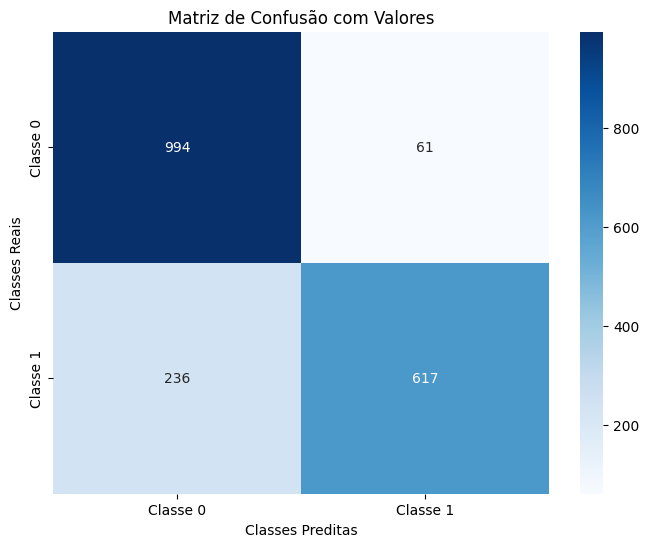

In [ ]:
# Gerando a matriz de confusão
cm = confusion_matrix(y_teste, y_pred)

# Plotando a matriz de confusão com os valores
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
plt.title('Matriz de Confusão com Valores')
plt.xlabel('Classes Preditas')
plt.ylabel('Classes Reais')
plt.show()